In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
import os
import json

In [2]:
# Load the variables
with open('./utils/variables.json', 'r') as file:
    variables = json.load(file)

SCR_feature_space = variables['SCR_feature_space']
LAB_feature_space = variables['LAB_feature_space']
train_len = variables['train_len']
test_len = variables['test_len']
print(len(SCR_feature_space), len(LAB_feature_space))
print(train_len, test_len)

# get num_processors for parallel computing
num_processors = multiprocessing.cpu_count()

7 40
8637 8542


In [3]:
figure_folder = "Main_results"

# Process Dataset

In [4]:
# read onset dadaset
dataset = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/dataset.csv")
# make sure the index is ordered
dataset = dataset.reset_index(drop=True)
assert len(dataset) == train_len + test_len

In [5]:
# split the dataset into train and test
data_train = dataset.iloc[:train_len, :].copy(deep = True)
data_test = dataset.iloc[train_len:, :].copy(deep = True)

# Run DTW with Missing Values

Since DTW-AROW does not require missing data imputation, we run it first. Then we impute the data and run normalization.

In [6]:
from utils.Distance_Computing import parallel_distance_matrix
from utils.Z_Helping_Functions import translate_dist_mtx_to_simi, fast_argsort

In [7]:
# for SCR we do not apply the same normalization as SCR, since the values are already in the same range (unit)
SCR_full = dataset.loc[:, SCR_feature_space].copy(deep = True)

In [8]:
# SCR_DTW_dist_full = parallel_distance_matrix(SCR_full, num_processors, get_DTW_distance)
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_imput2.npy', SCR_DTW_dist_full)

In [9]:
SCR_DTW_dist_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_imput2.npy')

In [10]:
# transfrom distance mtx to similarity score mtx by min-max normalization and substration from 1
SCR_DTW_simi_full = translate_dist_mtx_to_simi(SCR_DTW_dist_full)
# sort similarity score mtx into idx matrix by most similar rank highest. This is for the entire dataset, train + test
SCR_DTW_idx_full = fast_argsort(SCR_DTW_simi_full, num_processors)

In [11]:
# get the similarity matrix and idx rankings only for train set, this is for the one-vs-all training
SCR_DTW_dist_train = SCR_DTW_dist_full[:len(data_train), :len(data_train)]
SCR_DTW_simi_train = translate_dist_mtx_to_simi(SCR_DTW_dist_train)
SCR_DTW_idx_train = fast_argsort(SCR_DTW_simi_train, num_processors)

# Impute Missing Values in LAB and LAB

LAB: linear imputation

In [12]:
# SCR, since it just row wise we do not need to split into train and test
SCR_full = SCR_full.interpolate(method='linear', axis = 1)
SCR_full = SCR_full.bfill(axis=1)
SCR_full = SCR_full.ffill(axis=1)

In [13]:
# after imputation, we can safely split into train and test
SCR_train = SCR_full.iloc[:train_len, :].copy(deep = True)
SCR_test = SCR_full.iloc[train_len:, :].copy(deep = True)

LAB: MICE

In [14]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [15]:
# it is of note that the imputation is done on the lab train and lab test separately
# this is to avoid data leakage
LAB_train = data_train.loc[:, LAB_feature_space].copy(deep = True)
LAB_test = data_test.loc[:, LAB_feature_space].copy(deep = True)

In [16]:
# lab normalization
LAB_train = (LAB_train - LAB_train.min(skipna=True)) / (LAB_train.max(skipna=True) - LAB_train.min(skipna=True))
LAB_test = (LAB_test - LAB_test.min(skipna=True)) / (LAB_test.max(skipna=True) - LAB_test.min(skipna=True))
# impute lab missing values
imputer = IterativeImputer(missing_values=np.nan, max_iter=1000, random_state=42)
imputer.fit(LAB_train)
LAB_train_temp = imputer.transform(LAB_train)
LAB_test_temp = imputer.transform(LAB_test)
LAB_train.loc[:, :] = LAB_train_temp
LAB_test.loc[:, :] = LAB_test_temp
# Concate train and test
LAB_full = pd.concat([LAB_train, LAB_test], axis = 0)

# Compute Euclidean, Cosine and Manhattan Matrix of LAB and LAB

In [17]:
from utils.Distance_Computing import compute_similarity

In [18]:
# SCR
# Euclidean
SCR_Euc_simi_full, SCR_Euc_idx_full, SCR_Euc_simi_train, SCR_Euc_idx_train = compute_similarity(SCR_full, 'euclidean', train_len, num_processors)
# Cosine
SCR_Cos_simi_full, SCR_Cos_idx_full, SCR_Cos_simi_train, SCR_Cos_idx_train = compute_similarity(SCR_full, 'cosine', train_len, num_processors)
# Manhattan
SCR_Manh_simi_full, SCR_Manh_idx_full, SCR_Manh_simi_train, SCR_Manh_idx_train = compute_similarity(SCR_full, 'manhattan', train_len, num_processors)

In [19]:
# LAB
# Euclidean
LAB_Euc_simi_full, LAB_Euc_idx_full, LAB_Euc_simi_train, LAB_Euc_idx_train = compute_similarity(LAB_full, 'euclidean', train_len, num_processors)
# Cosine
LAB_Cos_simi_full, LAB_Cos_idx_full, LAB_Cos_simi_train, LAB_Cos_idx_train = compute_similarity(LAB_full, 'cosine', train_len, num_processors)
# Manhattan
LAB_Manh_simi_full, LAB_Manh_idx_full, LAB_Manh_simi_train, LAB_Manh_idx_train = compute_similarity(LAB_full, 'manhattan', train_len, num_processors)

In [20]:
# simi here is the un-ordered, normalized similarity score matrix, idx is the ordered paitent index matrix
# nw stands for not weighted by data overlap rates matrix
nw_fea_arrs_dict = {"SCR": {"DTW": {"simi": {"full": SCR_DTW_simi_full, "train": SCR_DTW_simi_train}, "idx": {"full": SCR_DTW_idx_full, "train": SCR_DTW_idx_train}}, 
                            "Euc": {"simi": {"full": SCR_Euc_simi_full, "train": SCR_Euc_simi_train}, "idx": {"full": SCR_Euc_idx_full, "train": SCR_Euc_idx_train}}, 
                            "Cos": {"simi": {"full": SCR_Cos_simi_full, "train": SCR_Cos_simi_train}, "idx": {"full": SCR_Cos_idx_full, "train": SCR_Cos_idx_train}}, 
                            "Manh":{"simi": {"full": SCR_Manh_simi_full, "train": SCR_Manh_simi_train}, "idx": {"full": SCR_Manh_idx_full, "train": SCR_Manh_idx_train}}}, 
                    "LAB": {"Euc": {"simi": {"full": LAB_Euc_simi_full, "train": LAB_Euc_simi_train}, "idx": {"full": LAB_Euc_idx_full, "train": LAB_Euc_idx_train}}, 
                            "Cos": {"simi": {"full": LAB_Cos_simi_full, "train": LAB_Cos_simi_train}, "idx": {"full": LAB_Cos_idx_full, "train": LAB_Cos_idx_train}}, 
                            "Manh":{"simi": {"full": LAB_Manh_simi_full, "train": LAB_Manh_simi_train}, "idx": {"full": LAB_Manh_idx_full, "train": LAB_Manh_idx_train}}}}

# Data Overlap Rates Weighting

In [21]:
# read pre-computed pairwise data overlap rates
SCR_overlap_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_overlap.npy')
LAB_overlap_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/lab_overlap.npy')

In [22]:
# consequently, we will only use the upper-left block of the overlap rate mtx for one-vs-all training
SCR_overlap_train = SCR_overlap_full[:train_len, :train_len]
LAB_overlap_train = LAB_overlap_full[:train_len, :train_len]

In [23]:
from utils.Distance_Computing import overlap_rates_weighting

In [24]:
# on full data (for testing)
# SCR
SCR_DTW_simi_wt_full, SCR_DTW_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["DTW"]["simi"]["full"], num_processors)
SCR_Euc_simi_wt_full, SCR_Euc_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Euc"]["simi"]["full"], num_processors)
SCR_Cos_simi_wt_full, SCR_Cos_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Cos"]["simi"]["full"], num_processors)
SCR_Manh_simi_wt_full, SCR_Manh_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Manh"]["simi"]["full"], num_processors)

In [25]:
# LAB
LAB_Euc_simi_wt_full, LAB_Euc_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Euc"]["simi"]["full"], num_processors)
LAB_Cos_simi_wt_full, LAB_Cos_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Cos"]["simi"]["full"], num_processors)
LAB_Manh_simi_wt_full, LAB_Manh_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Manh"]["simi"]["full"], num_processors)

In [26]:
# on training data (for one-vs-all training)
# SCR
SCR_DTW_simi_wt_train, SCR_DTW_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["DTW"]["simi"]["train"], num_processors)
SCR_Euc_simi_wt_train, SCR_Euc_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["Euc"]["simi"]["train"], num_processors)
SCR_Cos_simi_wt_train, SCR_Cos_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["Cos"]["simi"]["train"], num_processors)
SCR_Manh_simi_wt_train, SCR_Manh_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["Manh"]["simi"]["train"], num_processors)

In [27]:
# LAB
LAB_Euc_simi_wt_train, LAB_Euc_idx_wt_train = overlap_rates_weighting(LAB_overlap_train, nw_fea_arrs_dict["LAB"]["Euc"]["simi"]["train"], num_processors)
LAB_Cos_simi_wt_train, LAB_Cos_idx_wt_train = overlap_rates_weighting(LAB_overlap_train, nw_fea_arrs_dict["LAB"]["Cos"]["simi"]["train"], num_processors)
LAB_Manh_simi_wt_train, LAB_Manh_idx_wt_train = overlap_rates_weighting(LAB_overlap_train, nw_fea_arrs_dict["LAB"]["Manh"]["simi"]["train"], num_processors)

In [28]:
# simi here is the un-ordered, normalized similarity score matrix, idx is the ordered paitent index matrix
# nw stands for not weighted by data overlap rates matrix
wt_fea_arrs_dict = {"SCR": {"DTW": {"simi": {"full": SCR_DTW_simi_wt_full, "train": SCR_DTW_simi_wt_train}, "idx": {"full": SCR_DTW_idx_wt_full, "train": SCR_DTW_idx_wt_train}}, 
                            "Euc": {"simi": {"full": SCR_Euc_simi_wt_full, "train": SCR_Euc_simi_wt_train}, "idx": {"full": SCR_Euc_idx_wt_full, "train": SCR_Euc_idx_wt_train}}, 
                            "Cos": {"simi": {"full": SCR_Cos_simi_wt_full, "train": SCR_Cos_simi_wt_train}, "idx": {"full": SCR_Cos_idx_wt_full, "train": SCR_Cos_idx_wt_train}}, 
                            "Manh":{"simi": {"full": SCR_Manh_simi_wt_full, "train": SCR_Manh_simi_wt_train}, "idx": {"full": SCR_Manh_idx_wt_full, "train": SCR_Manh_idx_wt_train}}}, 
                    "LAB": {"Euc": {"simi": {"full": LAB_Euc_simi_wt_full, "train": LAB_Euc_simi_wt_train}, "idx": {"full": LAB_Euc_idx_wt_full, "train": LAB_Euc_idx_wt_train}}, 
                            "Cos": {"simi": {"full": LAB_Cos_simi_wt_full, "train": LAB_Cos_simi_wt_train}, "idx": {"full": LAB_Cos_idx_wt_full, "train": LAB_Cos_idx_wt_train}}, 
                            "Manh":{"simi": {"full": LAB_Manh_simi_wt_full, "train": LAB_Manh_simi_wt_train}, "idx": {"full": LAB_Manh_idx_wt_full, "train": LAB_Manh_idx_wt_train}}}}

# Optimize Distance Measures

In [29]:
# neighborhood sizes for optimizing best distance measures
k_sizes_train = [i for i in range(10, 201, 5)]
print(len(k_sizes_train))

39


In [30]:
# generate simi_dict for one-vs-all val
def process_idx_arr_for_optimizing(idx_arr: np.array, y_train: np.array) -> tuple[np.array, np.array]:
    idx_arr_clean = remove_row_idx(idx_arr)
    y_train_arr = sort_by_idx_arr(idx_arr_clean, y_train)
    return idx_arr_clean, y_train_arr

In [31]:
def remove_row_idx(idx_arr: np.array) -> np.array:    
    # Create a list to hold the new rows
    idx_arr_clean = []
    
    # Iterate through each row in the matrix
    for row_index in range(idx_arr.shape[0]):
        # Get the current row
        row = idx_arr[row_index]
        # Create a new row excluding the element equal to the row index
        new_row = row[row != row_index]
        # Append the new row to the new_matrix list
        idx_arr_clean.append(new_row)
    
    # Convert the list of rows back to a NumPy array
    idx_arr_clean = np.array(idx_arr_clean)
    
    return idx_arr_clean

In [32]:
def sort_by_idx_arr(idx_arr: np.array, y_train: np.array) -> np.array:
    y_train_arr = np.tile(y_train, (idx_arr.shape[0], 1))
    # Use advanced indexing to select the elements from matrix_b
    row_indices = np.arange(idx_arr.shape[0])[:, None]  # Create an array of row indices
    y_train_arr = y_train_arr[row_indices, idx_arr]  # Use the row indices and matrix_a for advanced indexing
    
    return y_train_arr

In [33]:
train_idx = list(data_train.index)
test_idx = list(data_test.index)
y_train = np.array(data_train["AKI_LABEL"])
y_test = np.array(data_test["AKI_LABEL"])
y_full = np.array(dataset["AKI_LABEL"])

Process the similarity score array into array that can be used for optimization

In [34]:
# SCR
SCR_idx_y_nw_dict_train = {}
SCR_idx_y_wt_dict_train = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["SCR"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    SCR_idx_y_nw_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["SCR"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    SCR_idx_y_wt_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}

100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


In [35]:
# Lab
LAB_idx_y_nw_dict_train = {}
LAB_idx_y_wt_dict_train = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["LAB"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    LAB_idx_y_nw_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["LAB"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    LAB_idx_y_wt_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}

100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Optimize distance measure at each k

In [36]:
from utils.Testing import KNN

In [37]:
def compare_distance_measures(clean_arrs_dict: dict, y_test: np.array, k_sizes: int) -> dict:
    
    best_method_each_k = {"name": [], "AUPRC": []}
    
    for k in tqdm(k_sizes):
        
        best_method_name = ''
        best_method_AUPRC = 0
        
        for name, arr_dict in clean_arrs_dict.items():
            AUPRC, _ = KNN(arr_dict, k, y_test)
            
            # if better AUPRC, update
            if AUPRC > best_method_AUPRC:
                best_method_name = name
                best_method_AUPRC = AUPRC
                
        best_method_each_k["name"].append(best_method_name)
        best_method_each_k["AUPRC"].append(best_method_AUPRC)
    
    return best_method_each_k    

In [38]:
# create a table to track all performance
# NW is not overlap rates weighting
# WT is overlap rates weighting
grid_search_table = pd.DataFrame('', index = k_sizes_train, columns = ["SCR NW", "LAB NW", "SCR WT", "LAB WT"])
grid_search_table.index.name = "k"

In [39]:
SCR_nw = compare_distance_measures(SCR_idx_y_nw_dict_train, y_train, k_sizes_train)
SCR_wt = compare_distance_measures(SCR_idx_y_wt_dict_train, y_train, k_sizes_train)
LAB_nw = compare_distance_measures(LAB_idx_y_nw_dict_train, y_train, k_sizes_train)
LAB_wt = compare_distance_measures(LAB_idx_y_wt_dict_train, y_train, k_sizes_train)

100%|██████████| 39/39 [00:04<00:00,  8.38it/s]


# Organize the Results

In [40]:
grid_search_table.loc[:, "SCR NW"] = SCR_nw["name"]
grid_search_table.loc[:, "SCR WT"] = SCR_wt["name"]
grid_search_table.loc[:, "LAB NW"] = LAB_nw["name"]
grid_search_table.loc[:, "LAB WT"] = LAB_wt["name"]

In [41]:
# To facilitate computing, we do not use the idea of unique distance measure for each k
# instead one metric for one condition. We use the metric that previal in the column
best_distance_measures = dict()
for column in grid_search_table.columns:
    mode_value = grid_search_table[column].mode()[0]
    best_distance_measures[column] = mode_value

# Test the Best Distance Measures on Test Set Using KNN/LR

Process the similarity score array into array that can be used for testing.

In [42]:
from utils.Testing import process_idx_arr_for_test, evluate_on_test_set

In [43]:
# SCR
SCR_idx_y_nw_dict_test = {}
SCR_idx_y_wt_dict_test = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["SCR"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    SCR_idx_y_nw_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["SCR"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    SCR_idx_y_wt_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}

100%|██████████| 4/4 [00:20<00:00,  5.03s/it]


In [44]:
# LAB
LAB_idx_y_nw_dict_test = {}
LAB_idx_y_wt_dict_test = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["LAB"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    LAB_idx_y_nw_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["LAB"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    LAB_idx_y_wt_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}

100%|██████████| 3/3 [00:14<00:00,  4.96s/it]


Evaluate the performance by using KNN/LR as the base model

In [45]:
# here we reduce the number of k to be tested
k_sizes_test = [i for i in range(10, 201, 10)]
print(len(k_sizes_test))

20


Save necessary materials for sensitivity analysis: nw_fea_arrs_dict (only full and simi), SCR_train, SCR_test, LAB_train, LAB_test, y_test, k_sizes_test

In [46]:
nw_fea_arrs_dict_for_save = {
    "SCR": {"DTW": {"simi": {"full": SCR_DTW_simi_full}}, 
            "Euc": {"simi": {"full": SCR_Euc_simi_full}}, 
            "Cos": {"simi": {"full": SCR_Cos_simi_full}}, 
            "Manh":{"simi": {"full": SCR_Manh_simi_full}}}, 
    "LAB": {"Euc": {"simi": {"full": LAB_Euc_simi_full}}, 
            "Cos": {"simi": {"full": LAB_Cos_simi_full}}, 
            "Manh":{"simi": {"full": LAB_Manh_simi_full}}},
    }

In [47]:
import pickle
varables_for_save = {
    "nw_fea_arrs_dict": nw_fea_arrs_dict_for_save,
    "SCR_train": SCR_train,
    "SCR_test": SCR_test,
    "LAB_train": LAB_train,
    "LAB_test": LAB_test,
    "y_test": y_test,
    'y_full': y_full,
    "k_sizes_test": k_sizes_test,
    'train_idx': train_idx,
    'test_idx': test_idx,
}
# Save all objects to a file
with open('/blue/yonghui.wu/lideyi/Personalization_Methodology/sensitivity_analysis/sensitivity_analysis_materials.pkl', 'wb') as file:
    pickle.dump(varables_for_save, file)


Main evaluation of overlap rates weighting

In [48]:
SCR_DTW_control_KNN, _ = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "DTW", "Euc", 
                                             y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                             LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 13.23it/s]


In [49]:
SCR_DTW_control_LR, _ = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "DTW", "Euc", 
                                             y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                             LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [14:16<00:00, 42.81s/it]


In [50]:
SCR_Euc_control_KNN, LAB_Euc_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Euc", "Euc", y_test, k_sizes_test, 
                                                               SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                               LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 12.42it/s]


In [51]:
SCR_Euc_control_LR, LAB_Euc_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Euc", "Euc", 
                                                             y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                             LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [13:22<00:00, 40.13s/it]


In [52]:
SCR_Cos_control_KNN, LAB_Cos_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Cos", "Cos", 
                                                               y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                               LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 12.27it/s]


In [53]:
SCR_Cos_control_LR, LAB_Cos_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Cos", "Cos", 
                                                               y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                               LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [13:26<00:00, 40.33s/it]


In [54]:
SCR_Manh_control_KNN, LAB_Manh_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Manh", "Manh", 
                                                                 y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                                 LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 12.22it/s]


In [55]:
SCR_Manh_control_LR, LAB_Manh_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Manh", "Manh", 
                                                                y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                                LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [14:19<00:00, 42.99s/it]


In [74]:
NW_WT_performace_results = {
    "SCR_DTW_control_KNN": SCR_DTW_control_KNN,
    "SCR_DTW_control_LR": SCR_DTW_control_LR,
    "SCR_Euc_control_KNN": SCR_Euc_control_KNN,
    "LAB_Euc_control_KNN": LAB_Euc_control_KNN,
    "SCR_Euc_control_LR": SCR_Euc_control_LR,
    "LAB_Euc_control_LR": LAB_Euc_control_LR,
    "SCR_Cos_control_KNN": SCR_Cos_control_KNN,
    "LAB_Cos_control_KNN": LAB_Cos_control_KNN,
    "SCR_Cos_control_LR": SCR_Cos_control_LR,
    "LAB_Cos_control_LR": LAB_Cos_control_LR,
    "SCR_Manh_control_KNN": SCR_Manh_control_KNN,
    "LAB_Manh_control_KNN": LAB_Manh_control_KNN,
    "SCR_Manh_control_LR": SCR_Manh_control_LR,
    "LAB_Manh_control_LR": LAB_Manh_control_LR,
}

# Save to a JSON file
with open("./Results_dict/Main_results/NW_WT_performace_results.json", "w") as json_file:
    json.dump(NW_WT_performace_results, json_file, indent=4)  # Use indent for readability

# Plot and Prove: Data Overlap Rates Weighting can Improve Performance

In [56]:
from utils.Plotting import plot_metric_along_k, add_subplot_index, save_figure

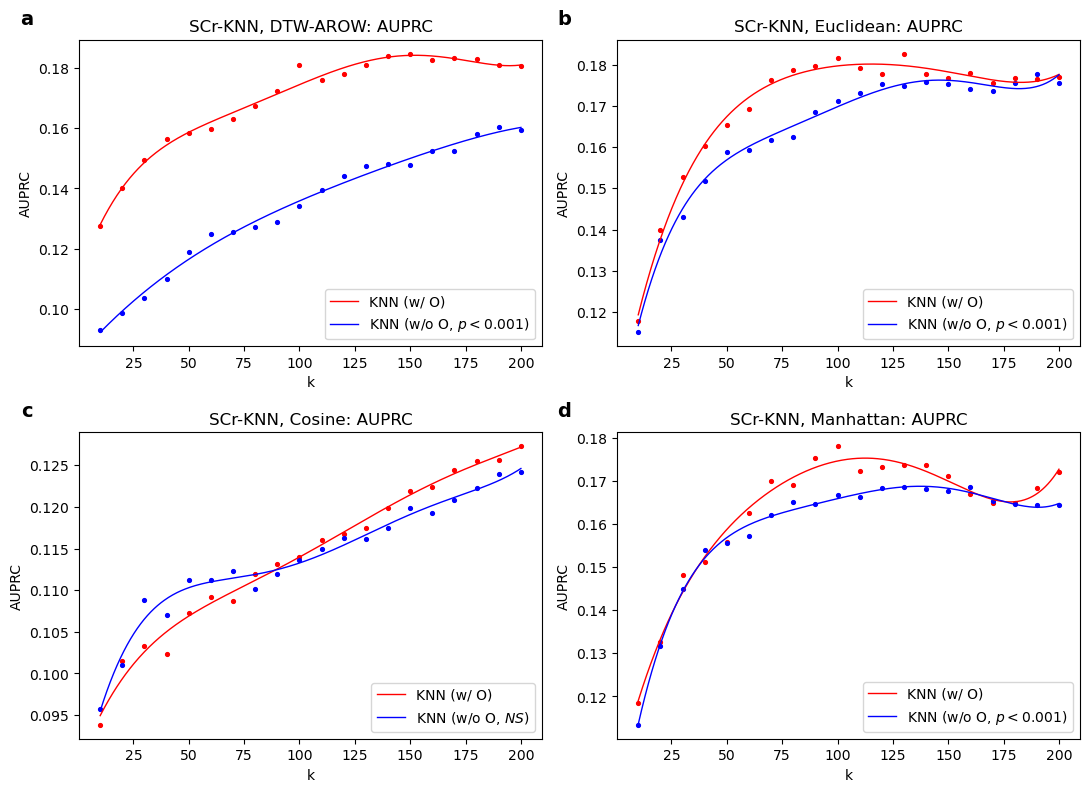

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/SCR-KNN-AUPRC.tif


In [57]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUPRC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_KNN["NW"][metric], SCR_DTW_control_KNN["WT"][metric], "SCr-KNN, DTW-AROW: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_KNN["NW"][metric], SCR_Euc_control_KNN["WT"][metric], "SCr-KNN, Euclidean: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_KNN["NW"][metric], SCR_Cos_control_KNN["WT"][metric], "SCr-KNN, Cosine: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_KNN["NW"][metric], SCR_Manh_control_KNN["WT"][metric], "SCr-KNN, Manhattan: %s"%(metric), metric, 'KNN')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-KNN-AUPRC")

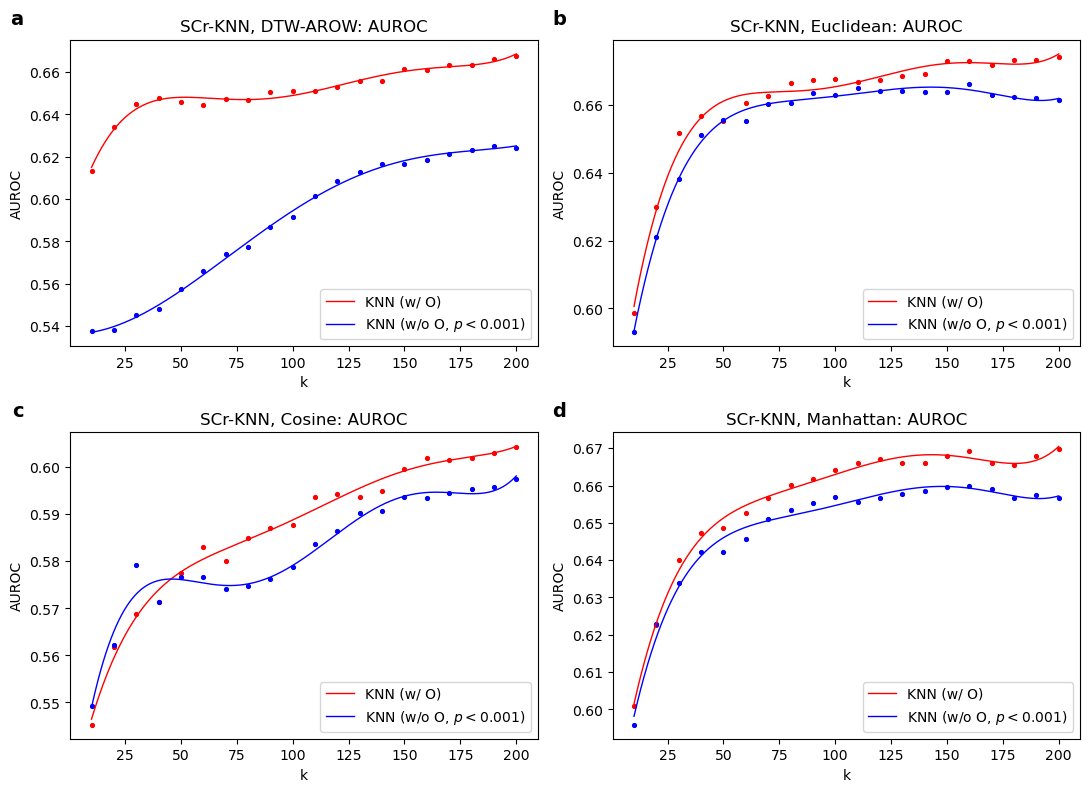

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/SCR-KNN-AUROC.tif


In [58]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUROC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_KNN["NW"][metric], SCR_DTW_control_KNN["WT"][metric], "SCr-KNN, DTW-AROW: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_KNN["NW"][metric], SCR_Euc_control_KNN["WT"][metric], "SCr-KNN, Euclidean: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_KNN["NW"][metric], SCR_Cos_control_KNN["WT"][metric], "SCr-KNN, Cosine: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_KNN["NW"][metric], SCR_Manh_control_KNN["WT"][metric], "SCr-KNN, Manhattan: %s"%(metric), metric, 'KNN')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-KNN-AUROC")

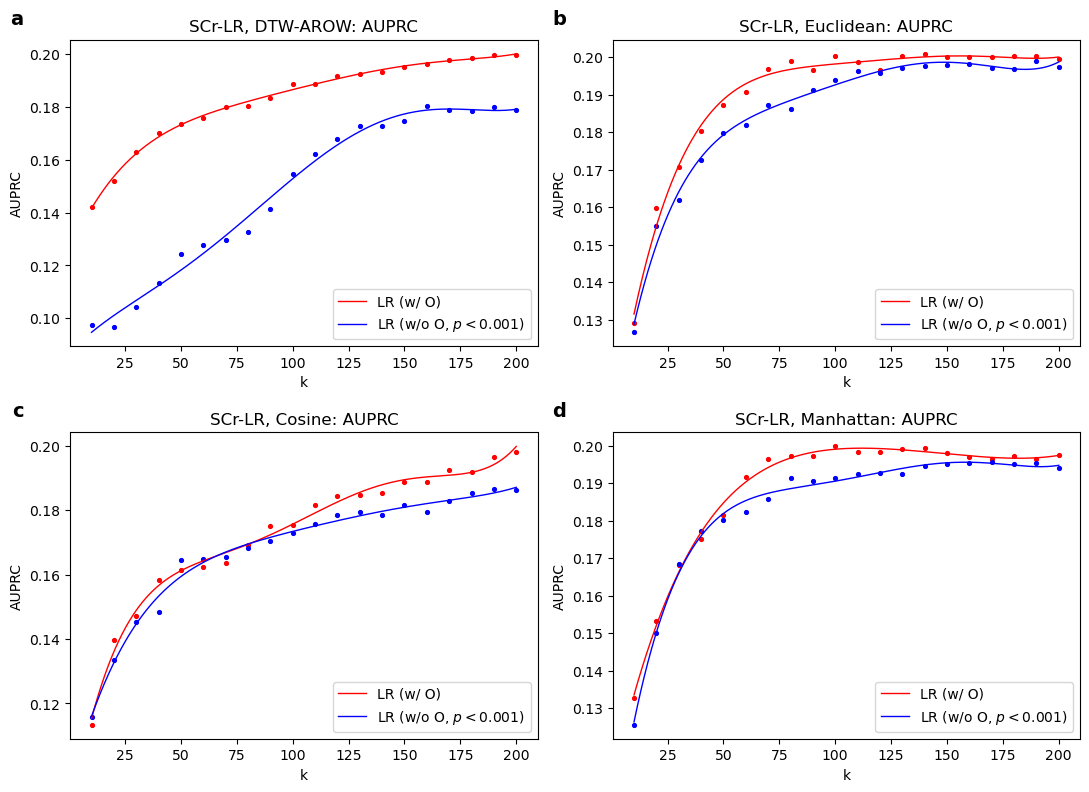

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/SCR-LR-AUPRC.tif


In [59]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUPRC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_LR["NW"][metric], SCR_DTW_control_LR["WT"][metric], "SCr-LR, DTW-AROW: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_LR["NW"][metric], SCR_Euc_control_LR["WT"][metric], "SCr-LR, Euclidean: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_LR["NW"][metric], SCR_Cos_control_LR["WT"][metric], "SCr-LR, Cosine: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_LR["NW"][metric], SCR_Manh_control_LR["WT"][metric], "SCr-LR, Manhattan: %s"%(metric), metric, "LR")
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-LR-AUPRC")

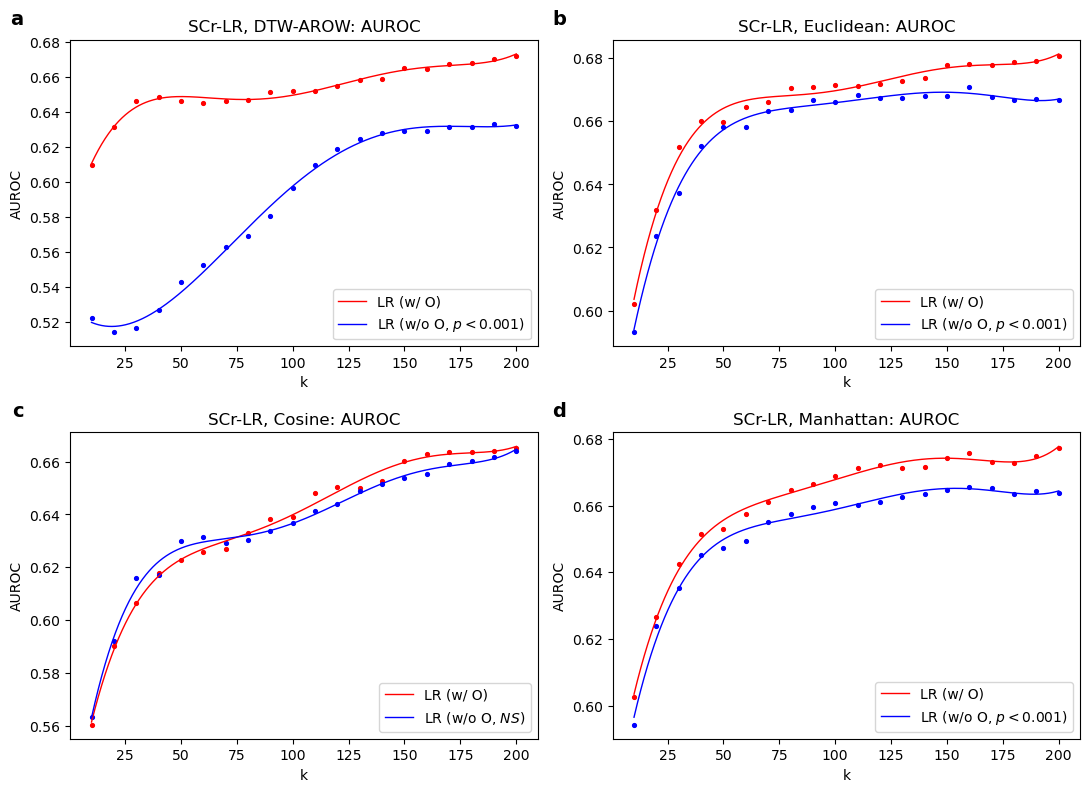

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/SCR-LR-AUROC.tif


In [60]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUROC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_LR["NW"][metric], SCR_DTW_control_LR["WT"][metric], "SCr-LR, DTW-AROW: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_LR["NW"][metric], SCR_Euc_control_LR["WT"][metric], "SCr-LR, Euclidean: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_LR["NW"][metric], SCR_Cos_control_LR["WT"][metric], "SCr-LR, Cosine: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_LR["NW"][metric], SCR_Manh_control_LR["WT"][metric], "SCr-LR, Manhattan: %s"%(metric), metric, "LR")
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-LR-AUROC")

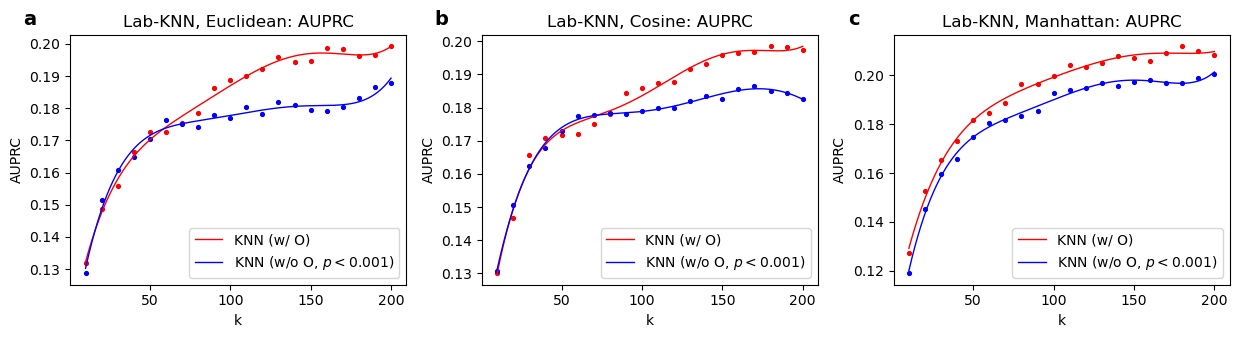

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/LAB-KNN-AUPRC.tif


In [61]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUPRC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_KNN["NW"][metric], LAB_Euc_control_KNN["WT"][metric], "Lab-KNN, Euclidean: %s"%(metric), metric, "KNN")
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_KNN["NW"][metric], LAB_Cos_control_KNN["WT"][metric], "Lab-KNN, Cosine: %s"%(metric), metric, "KNN")
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_KNN["NW"][metric], LAB_Manh_control_KNN["WT"][metric], "Lab-KNN, Manhattan: %s"%(metric), metric, "KNN")
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-KNN-AUPRC")

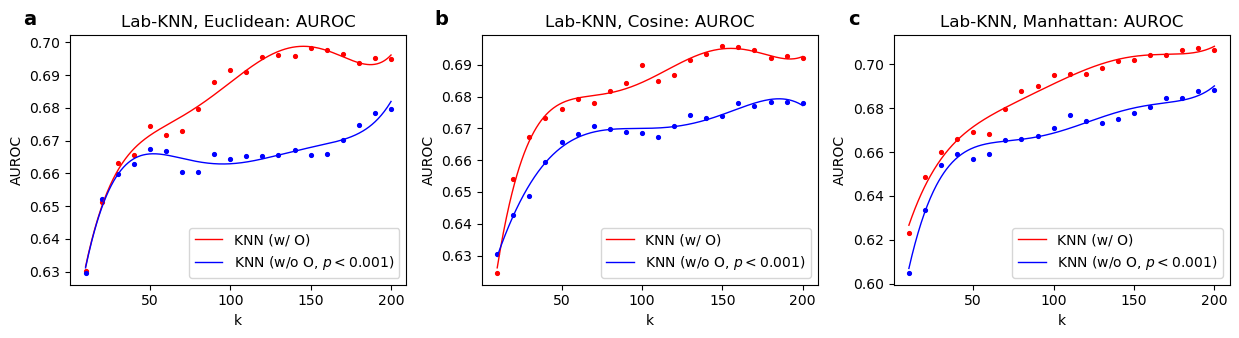

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/LAB-KNN-AUROC.tif


In [62]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUROC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_KNN["NW"][metric], LAB_Euc_control_KNN["WT"][metric], "Lab-KNN, Euclidean: %s"%(metric), metric, "KNN")
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_KNN["NW"][metric], LAB_Cos_control_KNN["WT"][metric], "Lab-KNN, Cosine: %s"%(metric), metric, "KNN")
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_KNN["NW"][metric], LAB_Manh_control_KNN["WT"][metric], "Lab-KNN, Manhattan: %s"%(metric), metric, "KNN")
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-KNN-AUROC")

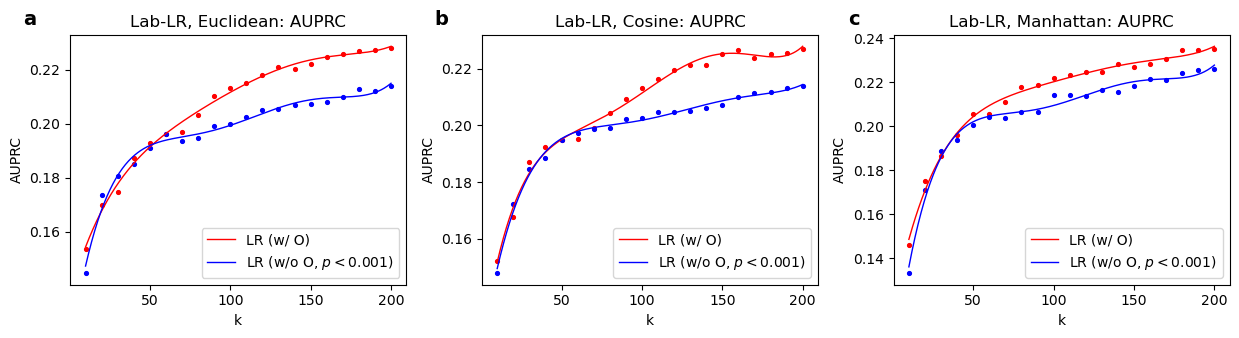

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/LAB-LR-AUPRC.tif


In [63]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUPRC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_LR["NW"][metric], LAB_Euc_control_LR["WT"][metric], "Lab-LR, Euclidean: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_LR["NW"][metric], LAB_Cos_control_LR["WT"][metric], "Lab-LR, Cosine: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_LR["NW"][metric], LAB_Manh_control_LR["WT"][metric], "Lab-LR, Manhattan: %s"%(metric), metric, "LR")
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-LR-AUPRC")

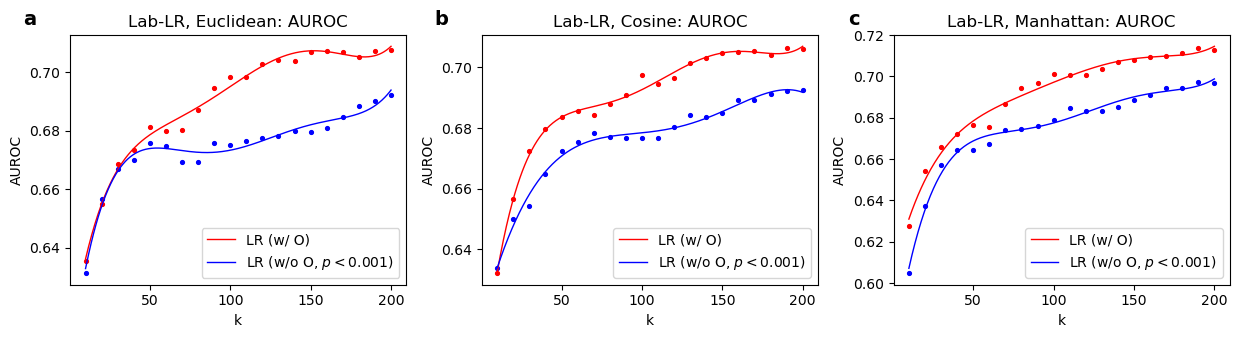

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/LAB-LR-AUROC.tif


In [64]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUROC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_LR["NW"][metric], LAB_Euc_control_LR["WT"][metric], "Lab-LR, Euclidean: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_LR["NW"][metric], LAB_Cos_control_LR["WT"][metric], "Lab-LR, Cosine: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_LR["NW"][metric], LAB_Manh_control_LR["WT"][metric], "Lab-LR, Manhattan: %s"%(metric), metric, "LR")
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-LR-AUROC")

# Plot and Prove: Distance Measure Optimization can Improve Performance

In [65]:
from utils.Plotting import plot_optim_vs_controls

In [66]:
SCR_nw_control_AUPRCs_KNN = [SCR_DTW_control_KNN["NW"]["AUPRC"], SCR_Euc_control_KNN["NW"]["AUPRC"],
                        SCR_Cos_control_KNN["NW"]["AUPRC"], SCR_Manh_control_KNN["NW"]["AUPRC"]]
SCR_nw_control_AUROCs_KNN = [SCR_DTW_control_KNN["NW"]["AUROC"], SCR_Euc_control_KNN["NW"]["AUROC"],
                        SCR_Cos_control_KNN["NW"]["AUROC"], SCR_Manh_control_KNN["NW"]["AUROC"]]
SCR_wt_control_AUPRCs_KNN = [SCR_DTW_control_KNN["WT"]["AUPRC"], SCR_Euc_control_KNN["WT"]["AUPRC"],
                        SCR_Cos_control_KNN["WT"]["AUPRC"], SCR_Manh_control_KNN["WT"]["AUPRC"]]
SCR_wt_control_AUROCs_KNN = [SCR_DTW_control_KNN["WT"]["AUROC"], SCR_Euc_control_KNN["WT"]["AUROC"],
                        SCR_Cos_control_KNN["WT"]["AUROC"], SCR_Manh_control_KNN["WT"]["AUROC"]]

In [67]:
SCR_nw_control_AUPRCs_LR = [SCR_DTW_control_LR["NW"]["AUPRC"], SCR_Euc_control_LR["NW"]["AUPRC"],
                        SCR_Cos_control_LR["NW"]["AUPRC"], SCR_Manh_control_LR["NW"]["AUPRC"]]
SCR_nw_control_AUROCs_LR = [SCR_DTW_control_LR["NW"]["AUROC"], SCR_Euc_control_LR["NW"]["AUROC"],
                        SCR_Cos_control_LR["NW"]["AUROC"], SCR_Manh_control_LR["NW"]["AUROC"]]
SCR_wt_control_AUPRCs_LR = [SCR_DTW_control_LR["WT"]["AUPRC"], SCR_Euc_control_LR["WT"]["AUPRC"],
                        SCR_Cos_control_LR["WT"]["AUPRC"], SCR_Manh_control_LR["WT"]["AUPRC"]]
SCR_wt_control_AUROCs_LR = [SCR_DTW_control_LR["WT"]["AUROC"], SCR_Euc_control_LR["WT"]["AUROC"],
                        SCR_Cos_control_LR["WT"]["AUROC"], SCR_Manh_control_LR["WT"]["AUROC"]]

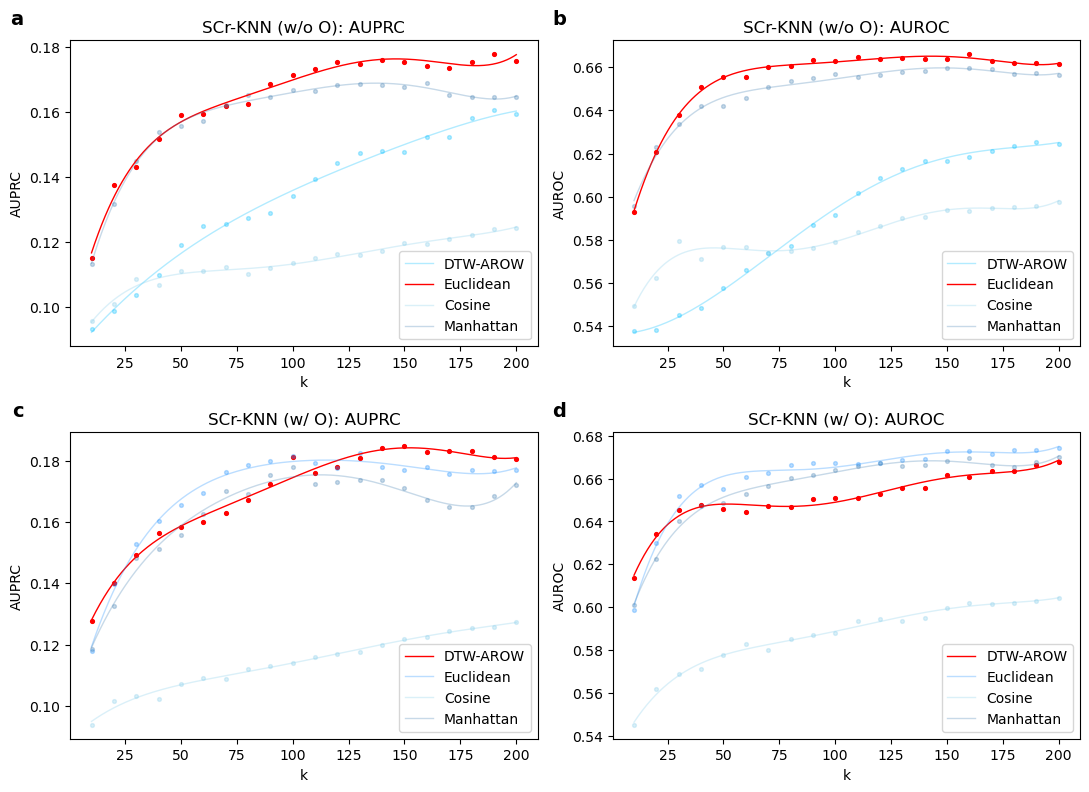

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/SCR-KNN-distance-measure.tif


In [68]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8))

plot_optim_vs_controls(axs[0, 0], k_sizes_test, SCR_nw_control_AUPRCs_KNN, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR NW"], 'SCr-KNN (w/o O)', 'AUPRC')
plot_optim_vs_controls(axs[0, 1], k_sizes_test, SCR_nw_control_AUROCs_KNN, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR NW"], 'SCr-KNN (w/o O)', 'AUROC')
plot_optim_vs_controls(axs[1, 0], k_sizes_test, SCR_wt_control_AUPRCs_KNN, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR WT"],'SCr-KNN (w/ O)', 'AUPRC')
plot_optim_vs_controls(axs[1, 1], k_sizes_test, SCR_wt_control_AUROCs_KNN, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR WT"],'SCr-KNN (w/ O)', 'AUROC')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-KNN-distance-measure")

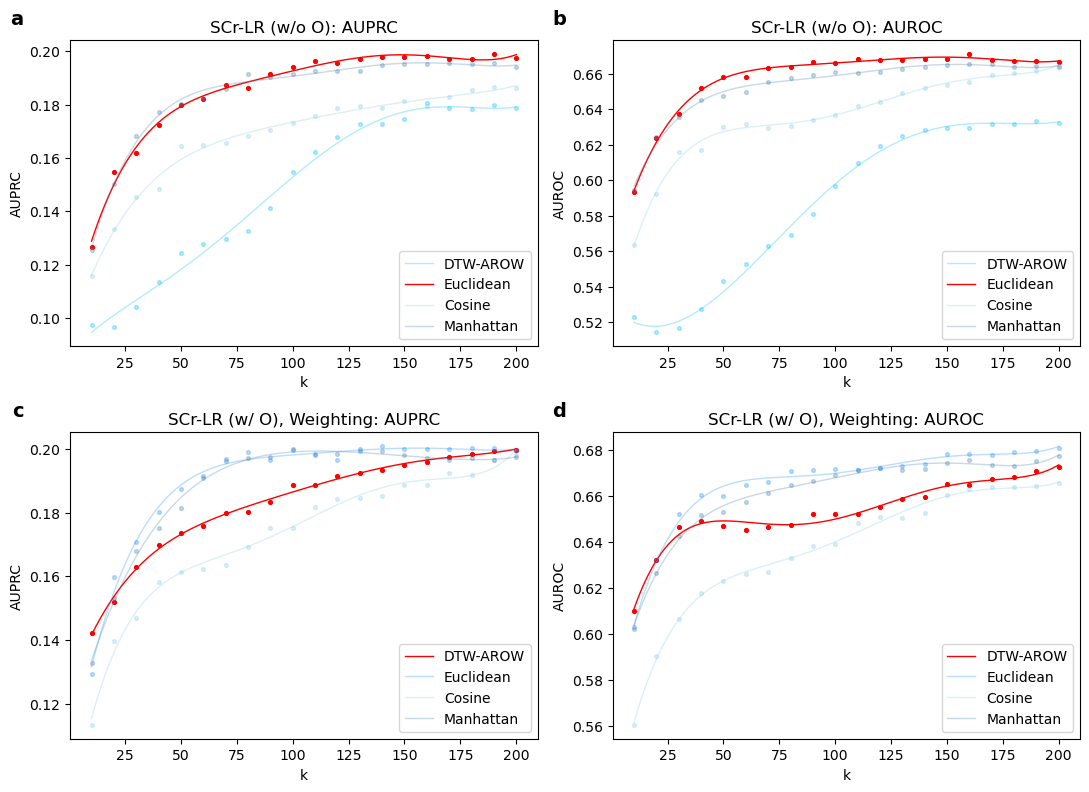

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/SCR-LR-distance-measure.tif


In [69]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8))

plot_optim_vs_controls(axs[0, 0], k_sizes_test, SCR_nw_control_AUPRCs_LR, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR NW"], 'SCr-LR (w/o O)', 'AUPRC')
plot_optim_vs_controls(axs[0, 1], k_sizes_test, SCR_nw_control_AUROCs_LR, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR NW"], 'SCr-LR (w/o O)', 'AUROC')
plot_optim_vs_controls(axs[1, 0], k_sizes_test, SCR_wt_control_AUPRCs_LR, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR WT"],'SCr-LR (w/ O), Weighting', 'AUPRC')
plot_optim_vs_controls(axs[1, 1], k_sizes_test, SCR_wt_control_AUROCs_LR, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR WT"],'SCr-LR (w/ O), Weighting', 'AUROC')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-LR-distance-measure")

In [70]:
LAB_nw_control_AUPRCs_KNN = [LAB_Euc_control_KNN["NW"]["AUPRC"], LAB_Cos_control_KNN["NW"]["AUPRC"], LAB_Manh_control_KNN["NW"]["AUPRC"]]
LAB_nw_control_AUROCs_KNN = [LAB_Euc_control_KNN["NW"]["AUROC"], LAB_Cos_control_KNN["NW"]["AUROC"], LAB_Manh_control_KNN["NW"]["AUROC"]]
LAB_wt_control_AUPRCs_KNN = [LAB_Euc_control_KNN["WT"]["AUPRC"], LAB_Cos_control_KNN["WT"]["AUPRC"], LAB_Manh_control_KNN["WT"]["AUPRC"]]
LAB_wt_control_AUROCs_KNN = [LAB_Euc_control_KNN["WT"]["AUROC"], LAB_Cos_control_KNN["WT"]["AUROC"], LAB_Manh_control_KNN["WT"]["AUROC"]]

In [71]:
LAB_nw_control_AUPRCs_LR = [LAB_Euc_control_LR["NW"]["AUPRC"], LAB_Cos_control_LR["NW"]["AUPRC"], LAB_Manh_control_LR["NW"]["AUPRC"]]
LAB_nw_control_AUROCs_LR = [LAB_Euc_control_LR["NW"]["AUROC"], LAB_Cos_control_LR["NW"]["AUROC"], LAB_Manh_control_LR["NW"]["AUROC"]]
LAB_wt_control_AUPRCs_LR = [LAB_Euc_control_LR["WT"]["AUPRC"], LAB_Cos_control_LR["WT"]["AUPRC"], LAB_Manh_control_LR["WT"]["AUPRC"]]
LAB_wt_control_AUROCs_LR = [LAB_Euc_control_LR["WT"]["AUROC"], LAB_Cos_control_LR["WT"]["AUROC"], LAB_Manh_control_LR["WT"]["AUROC"]]

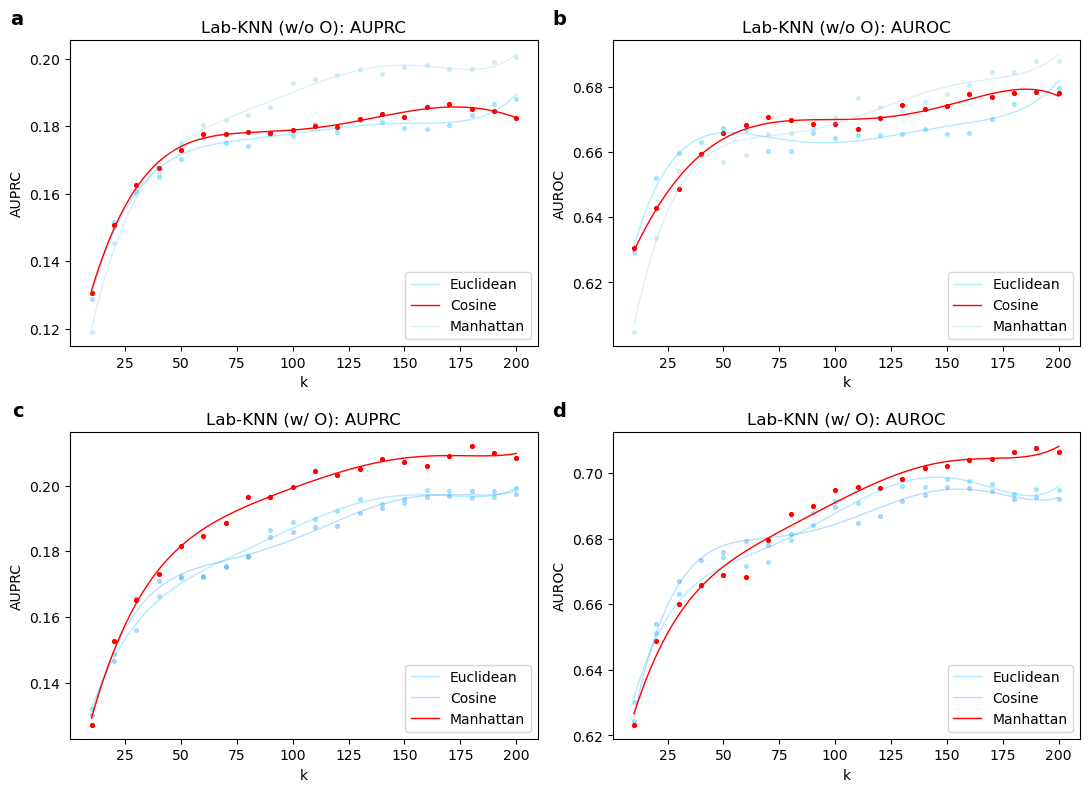

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/LAB-KNN-distance-measure.tif


In [72]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8))

plot_optim_vs_controls(axs[0, 0], k_sizes_test, LAB_nw_control_AUPRCs_KNN, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB NW"], 'Lab-KNN (w/o O)', 'AUPRC')
plot_optim_vs_controls(axs[0, 1], k_sizes_test, LAB_nw_control_AUROCs_KNN, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB NW"], 'Lab-KNN (w/o O)', 'AUROC')
plot_optim_vs_controls(axs[1, 0], k_sizes_test, LAB_wt_control_AUPRCs_KNN, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB WT"],'Lab-KNN (w/ O)', 'AUPRC')
plot_optim_vs_controls(axs[1, 1], k_sizes_test, LAB_wt_control_AUROCs_KNN, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB WT"],'Lab-KNN (w/ O)', 'AUROC')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-KNN-distance-measure")

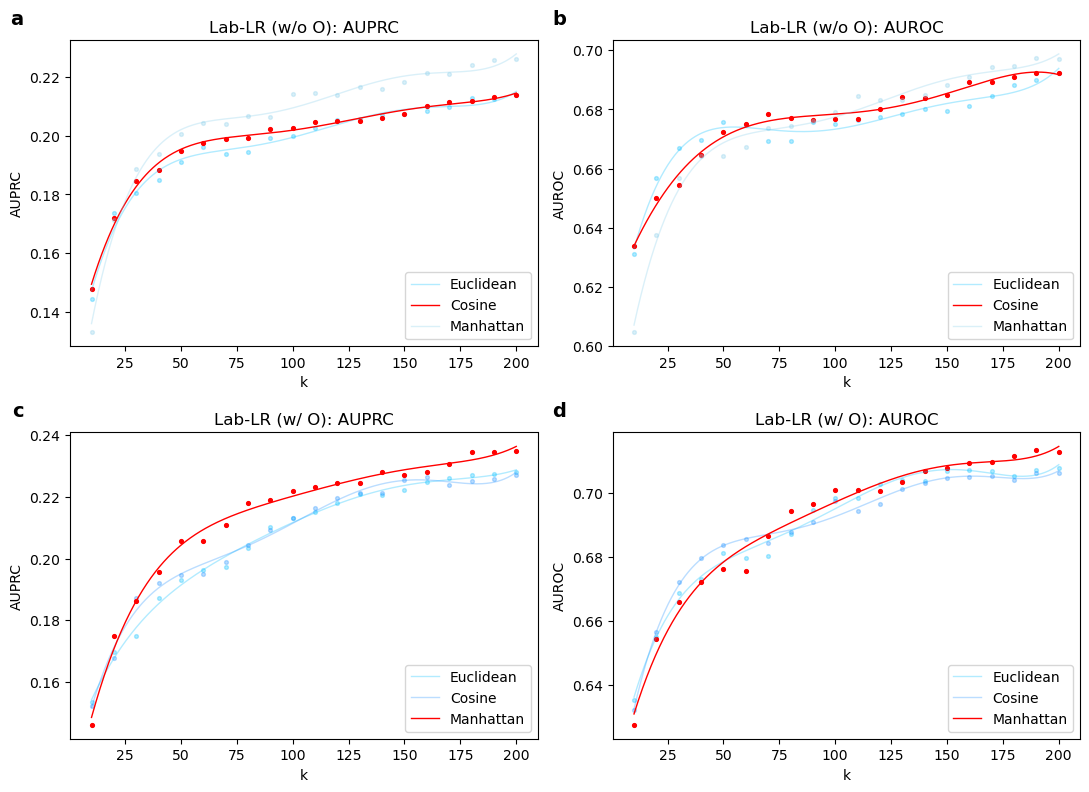

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/LAB-LR-distance-measure.tif


In [73]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8))

plot_optim_vs_controls(axs[0, 0], k_sizes_test, LAB_nw_control_AUPRCs_LR, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB NW"], 'Lab-LR (w/o O)', 'AUPRC')
plot_optim_vs_controls(axs[0, 1], k_sizes_test, LAB_nw_control_AUROCs_LR, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB NW"], 'Lab-LR (w/o O)', 'AUROC')
plot_optim_vs_controls(axs[1, 0], k_sizes_test, LAB_wt_control_AUPRCs_LR, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB WT"],'Lab-LR (w/ O)', 'AUPRC')
plot_optim_vs_controls(axs[1, 1], k_sizes_test, LAB_wt_control_AUROCs_LR, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB WT"],'Lab-LR (w/ O)', 'AUROC')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-LR-distance-measure")

# Optimize Feature Type Weights

In [81]:
opt_SCR_simi_nw_train = nw_fea_arrs_dict["SCR"][best_distance_measures["SCR NW"]]["simi"]["train"]
opt_LAB_simi_nw_train = nw_fea_arrs_dict["LAB"][best_distance_measures["LAB NW"]]["simi"]["train"]
opt_SCR_simi_wt_train = wt_fea_arrs_dict["SCR"][best_distance_measures["SCR WT"]]["simi"]["train"]
opt_LAB_simi_wt_train = wt_fea_arrs_dict["LAB"][best_distance_measures["LAB WT"]]["simi"]["train"]

opt_measure_simi_nw_train_dict = {"SCR": opt_SCR_simi_nw_train, "LAB": opt_LAB_simi_nw_train}
opt_measure_simi_wt_train_dict = {"SCR": opt_SCR_simi_wt_train, "LAB": opt_LAB_simi_wt_train}

In [82]:
# get feature type weight combination
# A is for weighting SCR, B is for LAB
weight_combines = []
for A in np.arange(0.1, 1.1, 0.1):
    for B in np.arange(0.1, 1.1, 0.1):
        if A + B == 1:
            weight_combines.append((round(A, 1), round(B, 1)))  
print(len(weight_combines))

9


Feature type weight optimization

In [83]:
from utils.Z_Helping_Functions import min_max_normalization, fast_argsort

In [84]:
def optimize_feature_type_weights(ref_measure_simi_train_dict: dict, k_sizes: list, weight_combines: list, 
                                  y_train: np.array, num_processors: int) -> list:
    results = []
    for k in tqdm(k_sizes):
        result_at_k = evaluate_feature_type_weights_at_single_k(ref_measure_simi_train_dict, k, weight_combines, y_train, num_processors)
        results.append(result_at_k)
    return results

In [85]:
# Worker function to handle all weight combinations for a single k
def evaluate_feature_type_weights_at_single_k(ref_measure_simi_train_dict: dict, k: int, 
                                              weight_combines: list, y_train: np.array, num_processors: int) -> list:
    # Get the best feature type similarity measures for the current k
    # Retrieve best similarity arrays
    SCR_simi_train, LAB_simi_train = ref_measure_simi_train_dict["SCR"], ref_measure_simi_train_dict["LAB"]
    
    assert(SCR_simi_train.shape[0] == LAB_simi_train.shape[0])
    assert(SCR_simi_train.shape[1] == LAB_simi_train.shape[1])

    best_AUPRC = 0
    best_weight_combo = None

    # Iterate over all weight combinations
    for (A, B) in weight_combines:
        AUPRC, _ = evaluate_feature_type_weights(SCR_simi_train, LAB_simi_train, A, B, y_train, k, num_processors)
        if AUPRC > best_AUPRC:
            best_AUPRC = AUPRC
            best_weight_combo = (A, B)

    return [k, best_AUPRC, best_weight_combo]

In [86]:
def evaluate_feature_type_weights(SCR_simi_train, LAB_simi_train, A, B, y_train, k, num_processors):
    # weighted sum of the simi mtxs and min-max normalization 
    combined_simi_train = A * SCR_simi_train + B * LAB_simi_train
    combined_simi_train = min_max_normalization(combined_simi_train, axis = 1)
    # get the ordered idx
    combined_idx_train = fast_argsort(combined_simi_train, num_processors)
    # organize the sorted idx into dict
    idx_arr_train_combined, y_train_arr_combined = process_idx_arr_for_optimizing(combined_idx_train, y_train)
    idx_y_wt_dict_train_combined = {"idx": idx_arr_train_combined, "label": y_train_arr_combined}
    #evluate the KNN results
    AUPRC, AUROC = KNN(idx_y_wt_dict_train_combined, k, y_train)
    return AUPRC, AUROC

In [ ]:
weights_performance_nw_train = optimize_feature_type_weights(opt_measure_simi_nw_train_dict, k_sizes_train, 
                                                             weight_combines, y_train, num_processors)

In [ ]:
weights_performance_wt_train = optimize_feature_type_weights(opt_measure_simi_wt_train_dict, k_sizes_train, 
                                                             weight_combines, y_train, num_processors)

In [ ]:
grid_search_table["COMBINE NW"] = [perf[2] for perf in weights_performance_nw_train]
grid_search_table["COMBINE WT"] = [perf[2] for perf in weights_performance_wt_train]

In [ ]:
grid_search_table.to_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/grid_search_table_imput2_LR.csv", index = True)

In [76]:
grid_search_table = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/grid_search_table_imput2_LR.csv", index_col = 0)

# Evaluate Final Performance on Test Set

In [222]:
from utils.Testing import test_final_personalized_model, get_best_weights, combine_best_weights_for_test, predict_by_LR

In [101]:
opt_SCR_simi_nw_full = nw_fea_arrs_dict["SCR"][best_distance_measures["SCR NW"]]["simi"]["full"]
opt_LAB_simi_nw_full = nw_fea_arrs_dict["LAB"][best_distance_measures["LAB NW"]]["simi"]["full"]
opt_SCR_simi_wt_full = wt_fea_arrs_dict["SCR"][best_distance_measures["SCR WT"]]["simi"]["full"]
opt_LAB_simi_wt_full = wt_fea_arrs_dict["LAB"][best_distance_measures["LAB WT"]]["simi"]["full"]

opt_measure_simi_nw_full_dict = {"SCR": opt_SCR_simi_nw_full, "LAB": opt_LAB_simi_nw_full}
opt_measure_simi_wt_full_dict = {"SCR": opt_SCR_simi_wt_full, "LAB": opt_LAB_simi_wt_full}

In [224]:
# these are the no nan features
X_train = pd.concat([SCR_train, LAB_train], axis = 1)
X_test = pd.concat([SCR_test, LAB_test], axis = 1)
assert X_train.shape[1] == X_test.shape[1]
# assert no nan values
assert not X_train.isnull().values.any()
assert not X_test.isnull().values.any()

Performance 1: Optimized distance measure + optimized feature type weights + no overlap rates weighting

In [ ]:
final_model_performance_nw_KNN = test_final_personalized_model(X_train, X_test, k_sizes_test, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_nw_full_dict, 
                                                           num_processors, "KNN", False)

In [ ]:
final_model_performance_nw_LR = test_final_personalized_model(X_train, X_test, k_sizes_test, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_nw_full_dict, 
                                                           num_processors, "LR", False)

Performance 2: Optimized distance measure + optimized feature type weights + overlap rates weighting

In [ ]:
final_model_performance_wt_KNN = test_final_personalized_model(X_train, X_test, k_sizes_test, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_wt_full_dict, 
                                                           num_processors, "KNN", True)

In [ ]:
final_model_performance_wt_LR = test_final_personalized_model(X_train, X_test, k_sizes_test, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_wt_full_dict, 
                                                           num_processors, "LR", True)

Performance 3: Fixed Euclidean distance + fixed feature type weights, k = 20 + no overlap rates weighting

In [262]:
base_k = 20
base_fix_distance_performance_nw_KNN = {"AUPRC": [], "AUROC": []}
base_fix_distance_performance_nw_LR = {"AUPRC": [], "AUROC": []}
A_nw, B_nw = eval(get_best_weights(grid_search_table, base_k, False))
base_fix_SCR_simi_nw_full = nw_fea_arrs_dict["SCR"]["DTW"]["simi"]["full"]
base_fix_LAB_simi_nw_full = nw_fea_arrs_dict["LAB"]["Euc"]["simi"]["full"]
fix_combined_weights_dict_nw = combine_best_weights_for_test(base_fix_SCR_simi_nw_full, base_fix_LAB_simi_nw_full, A_nw, B_nw, train_idx, test_idx, y_full, num_processors)

In [ ]:
for k in tqdm(k_sizes_test):
    base_AUPRC_nw_KNN, base_AUROC_nw_KNN = KNN(fix_combined_weights_dict_nw, k, y_test)
    base_fix_distance_performance_nw_KNN["AUPRC"].append(base_AUPRC_nw_KNN)
    base_fix_distance_performance_nw_KNN["AUROC"].append(base_AUROC_nw_KNN)
    base_AUPRC_nw_LR, base_AUROC_nw_LR = predict_by_LR(X_train, X_test, fix_combined_weights_dict_nw, k, y_test)
    base_fix_distance_performance_nw_LR["AUPRC"].append(base_AUPRC_nw_LR)
    base_fix_distance_performance_nw_LR["AUROC"].append(base_AUROC_nw_LR)

Performance 4: Optimized distance measure + fixed feature type weights, k = 20 + no overlap rates weighting

In [263]:
base_opt_distance_performance_nw_KNN = {"AUPRC": [], "AUROC": []}
base_opt_distance_performance_nw_LR = {"AUPRC": [], "AUROC": []}
base_opt_SCR_simi_nw_full = nw_fea_arrs_dict["SCR"][best_distance_measures["SCR NW"]]["simi"]["full"]
base_opt_LAB_simi_nw_full = nw_fea_arrs_dict["LAB"][best_distance_measures["LAB NW"]]["simi"]["full"]
fix_combined_weights_dict_nw = combine_best_weights_for_test(base_opt_SCR_simi_nw_full, base_opt_LAB_simi_nw_full, A_nw, B_nw, train_idx, test_idx, y_full, num_processors)

In [ ]:
for k in tqdm(k_sizes_test):
    base_AUPRC_nw_KNN, base_AUROC_nw_KNN = KNN(fix_combined_weights_dict_nw, k, y_test)
    base_opt_distance_performance_nw_KNN["AUPRC"].append(base_AUPRC_nw_KNN)
    base_opt_distance_performance_nw_KNN["AUROC"].append(base_AUROC_nw_KNN)
    base_AUPRC_nw_LR, base_AUROC_nw_LR = predict_by_LR(X_train, X_test, fix_combined_weights_dict_nw, k, y_test)
    base_opt_distance_performance_nw_LR["AUPRC"].append(base_AUPRC_nw_LR)
    base_opt_distance_performance_nw_LR["AUROC"].append(base_AUROC_nw_LR)

Performance 5: Global Euclidean Distance

In [229]:
X_train_norm = X_train.copy(deep = True)
X_test_norm = X_test.copy(deep = True) 
X_train_norm.loc[:, :] = min_max_normalization(X_train_norm, axis = 0)
X_test_norm.loc[:, :] = min_max_normalization(X_test_norm, axis = 0)
X_full_norm = pd.concat([X_train_norm, X_test_norm], axis = 0)

In [230]:
_, X_Euc_idx_full, _, _ = compute_similarity(X_full_norm, 'euclidean', train_len, num_processors)
Euc_idx_arr_test_glob, Euc_y_test_arr_glob = process_idx_arr_for_test(train_idx, test_idx, X_Euc_idx_full, y_full)
glob_Euc_idx_y_dict_test = {"idx": Euc_idx_arr_test_glob, "label": Euc_y_test_arr_glob}

In [ ]:
base_glob_Euc_performance_KNN = {"AUPRC": [], "AUROC": []}
base_glob_Euc_performance_LR = {"AUPRC": [], "AUROC": []}
for k in tqdm(k_sizes_test):
    base_AUPRC_glob_KNN, base_AUROC_glob_KNN = KNN(glob_Euc_idx_y_dict_test, k, y_test)
    base_glob_Euc_performance_KNN["AUPRC"].append(base_AUPRC_glob_KNN)
    base_glob_Euc_performance_KNN["AUROC"].append(base_AUROC_glob_KNN)
    base_AUPRC_glob_LR, base_AUROC_glob_LR = predict_by_LR(X_train, X_test, glob_Euc_idx_y_dict_test, k, y_test)
    base_glob_Euc_performance_LR["AUPRC"].append(base_AUPRC_glob_LR)
    base_glob_Euc_performance_LR["AUROC"].append(base_AUROC_glob_LR)

Performance 6: Global Cosine Distance

In [232]:
_, X_Cos_idx_full, _, _ = compute_similarity(X_full_norm, 'cosine', train_len, num_processors)
Cos_idx_arr_test_glob, Cos_y_test_arr_glob = process_idx_arr_for_test(train_idx, test_idx, X_Cos_idx_full, y_full)
glob_Cos_idx_y_dict_test = {"idx": Cos_idx_arr_test_glob, "label": Cos_y_test_arr_glob}

In [ ]:
base_glob_Cos_performance_KNN = {"AUPRC": [], "AUROC": []}
base_glob_Cos_performance_LR = {"AUPRC": [], "AUROC": []}
for k in tqdm(k_sizes_test):
    base_AUPRC_glob_KNN, base_AUROC_glob_KNN = KNN(glob_Cos_idx_y_dict_test, k, y_test)
    base_glob_Cos_performance_KNN["AUPRC"].append(base_AUPRC_glob_KNN)
    base_glob_Cos_performance_KNN["AUROC"].append(base_AUROC_glob_KNN)
    base_AUPRC_glob_LR, base_AUROC_glob_LR = predict_by_LR(X_train, X_test, glob_Cos_idx_y_dict_test, k, y_test)
    base_glob_Cos_performance_LR["AUPRC"].append(base_AUPRC_glob_LR)
    base_glob_Cos_performance_LR["AUROC"].append(base_AUROC_glob_LR)

# Plot the Final Performance of Personalized Models 

In [ ]:
# save results
# List of dictionaries and their desired filenames
dicts_to_save = {
    "base_glob_Euc_performance_KNN": base_glob_Euc_performance_KNN,
    "base_glob_Cos_performance_KNN": base_glob_Cos_performance_KNN,
    "base_fix_distance_performance_nw_KNN": base_fix_distance_performance_nw_KNN,
    "base_opt_distance_performance_nw_KNN": base_opt_distance_performance_nw_KNN,
    "final_model_performance_nw_KNN": final_model_performance_nw_KNN,
    "final_model_performance_wt_KNN": final_model_performance_wt_KNN,
    "base_glob_Euc_performance_LR": base_glob_Euc_performance_LR,
    "base_glob_Cos_performance_LR": base_glob_Cos_performance_LR,
    "base_fix_distance_performance_nw_LR": base_fix_distance_performance_nw_LR,
    "base_opt_distance_performance_nw_LR": base_opt_distance_performance_nw_LR,
    "final_model_performance_nw_LR": final_model_performance_nw_LR,
    "final_model_performance_wt_LR": final_model_performance_wt_LR,
}

# Directory to save the JSON files
output_dir = "./Results_dict/Main_results/"

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Save each dictionary as a JSON file
for filename, data in dicts_to_save.items():
    file_path = os.path.join(output_dir, f"{filename}.json")
    with open(file_path, "w") as json_file:
        json.dump(data, json_file, indent=4)  # Use indent=4 for pretty formatting
    print(f"Saved {filename} to {file_path}")

In [102]:
# Directory containing the JSON files
input_dir = "./Results_dict/Main_results/"

# Dictionary to store the loaded data
loaded_dicts = {}

# Load each JSON file and assign it to the corresponding variable name
for filename in os.listdir(input_dir):
    if filename.endswith(".json"):  # Process only JSON files
        file_path = os.path.join(input_dir, filename)
        variable_name = filename.replace(".json", "")  # Remove .json to create the variable name
        with open(file_path, "r") as json_file:
            globals()[variable_name] = json.load(json_file)

In [241]:
from utils.Plotting import plot_final_performance_metrics

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 9.5)) 

plot_final_performance_metrics(axs[0, 0], k_sizes_test, "AUPRC", base_glob_Euc_performance_KNN, base_glob_Cos_performance_KNN, base_fix_distance_performance_nw_KNN, base_opt_distance_performance_nw_KNN, final_model_performance_nw_KNN, final_model_performance_wt_KNN, "KNN")
plot_final_performance_metrics(axs[0, 1], k_sizes_test, "AUROC", base_glob_Euc_performance_KNN, base_glob_Cos_performance_KNN, base_fix_distance_performance_nw_KNN, base_opt_distance_performance_nw_KNN, final_model_performance_nw_KNN, final_model_performance_wt_KNN, "KNN")
plot_final_performance_metrics(axs[1, 0], k_sizes_test, "AUPRC", base_glob_Euc_performance_LR, base_glob_Cos_performance_LR, base_fix_distance_performance_nw_LR, base_opt_distance_performance_nw_LR, final_model_performance_nw_LR, final_model_performance_wt_LR, "Personalized LR")
plot_final_performance_metrics(axs[1, 1], k_sizes_test, "AUROC", base_glob_Euc_performance_LR, base_glob_Cos_performance_LR, base_fix_distance_performance_nw_LR, base_opt_distance_performance_nw_LR, final_model_performance_nw_LR, final_model_performance_wt_LR, "Personalized LR")
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "Final_model_performance")

# Evaluate Control Feature Type Weights on Test Set

In [ ]:
from utils.Testing import combine_best_weights_for_test

In [ ]:
def get_weight_control_performance(k_sizes: list, weight_combines: list, train_idx: list, 
                                   test_idx: list, y_full: np.array, y_test: np.array, 
                                   opt_measure_simi_full_dict: dict, num_processors: int) -> dict:
    results = dict()
    
    # get the corresponding simi mtx
    SCR_simi_full, LAB_simi_full = opt_measure_simi_full_dict["SCR"], opt_measure_simi_full_dict["LAB"]
    
    for (A, B) in tqdm(weight_combines):
        
        results[str((A, B))] = {"AUPRC": [], "AUROC": []}
        
        combined_weights_dict = combine_best_weights_for_test(SCR_simi_full, LAB_simi_full, A, B, 
                                                              train_idx, test_idx, y_full, num_processors) 
        for k in k_sizes:
            
            AUPRC_full, AUROC_full = KNN(combined_weights_dict, k, y_test)
            
            results[str((A, B))]["AUPRC"].append(AUPRC_full)
            results[str((A, B))]["AUROC"].append(AUROC_full)
        
    return results

In [ ]:
all_weights_performance_nw = get_weight_control_performance(k_sizes_test, weight_combines, 
                                                            train_idx, test_idx, y_full, y_test, 
                                                            opt_measure_simi_nw_full_dict, num_processors)

In [ ]:
all_weights_performance_wt = get_weight_control_performance(k_sizes_test, weight_combines, 
                                                            train_idx, test_idx, y_full, y_test, 
                                                            opt_measure_simi_wt_full_dict, num_processors)

In [ ]:
def plot_all_weights_performance(ax, k_sizes, all_weights_performance, 
                                 final_model_performance, title, metric):
    
    candidate_linecolor = ['lightblue', 'skyblue', 'deepskyblue', 
                           'dodgerblue', 'cornflowerblue', 'royalblue', 
                           'steelblue', 'mediumblue', 'darkblue', 'navy', 
                           'midnightblue', 'slateblue', 'powderblue', 'cadetblue']
    
    for i, weight_performance in enumerate(all_weights_performance.values()):
        if i == 0:
            label = "Fixed feature type weights"
        else:
            label = ""
            
        ax.plot(k_sizes, weight_performance[metric], alpha = 0.25, marker='.', 
                markersize=10, color = candidate_linecolor[i], label = label)
        
    ax.plot(k_sizes, final_model_performance[metric], color = "red", alpha = 1,
            label = "Dynamic feature type weights", marker='.', markersize=7)
        
    ax.set_title(title + ": " + metric)
    ax.set_xlabel('k')
    ax.set_ylabel(metric)
    ax.legend()

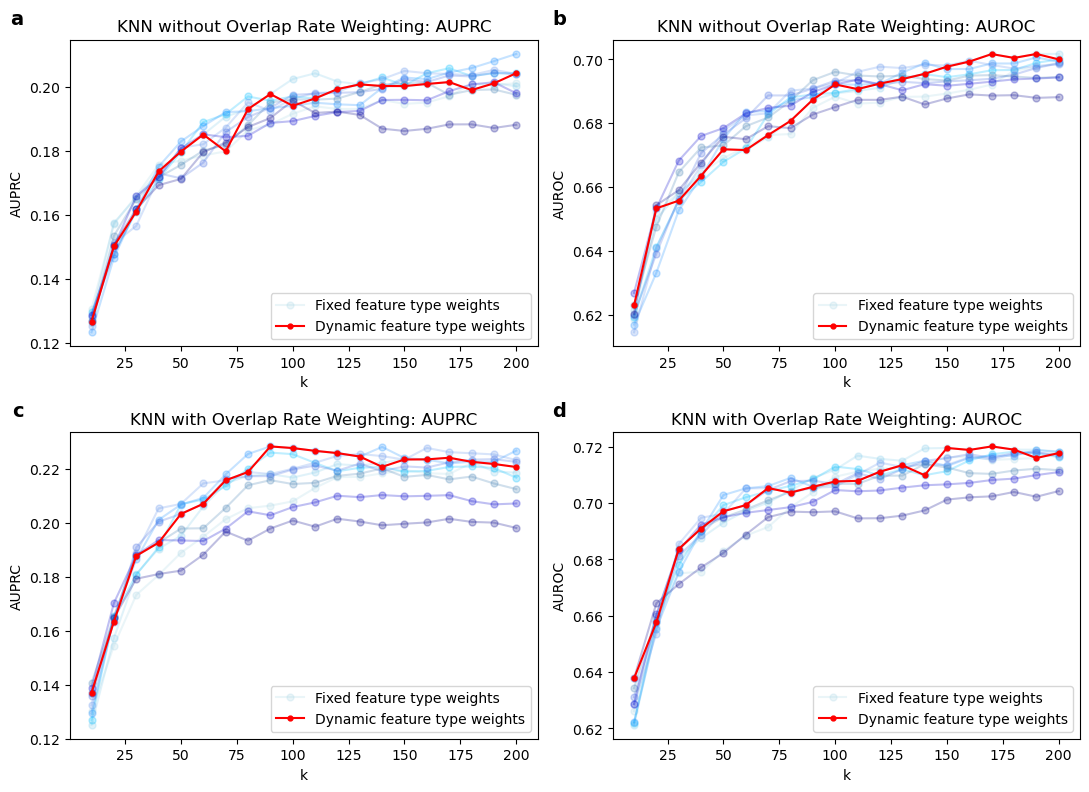

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Main_results/All-feature-type-weights-performance.tif


In [108]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8))

plot_all_weights_performance(axs[0, 0], k_sizes_test, all_weights_performance_nw, 
                                      final_model_performance_nw_KNN, "KNN without Overlap Rate Weighting", "AUPRC")
plot_all_weights_performance(axs[0, 1], k_sizes_test, all_weights_performance_nw, 
                                      final_model_performance_nw_KNN, "KNN without Overlap Rate Weighting", "AUROC")
plot_all_weights_performance(axs[1, 0], k_sizes_test, all_weights_performance_wt, 
                                      final_model_performance_wt_KNN, "KNN with Overlap Rate Weighting", "AUPRC")
plot_all_weights_performance(axs[1, 1], k_sizes_test, all_weights_performance_wt, 
                                      final_model_performance_wt_KNN, "KNN with Overlap Rate Weighting", "AUROC")
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "All-feature-type-weights-performance")

# Output Predicted Label Probabilities for Sub-group Analysis

We get predictions all on k = 50


In [244]:
base_k_for_subgroup = [50]

Performance 2: Optimized distance measure + optimized feature type weights + overlap rates weighting

In [245]:
final_pred_proba_wt_KNN = test_final_personalized_model(X_train, X_test, base_k_for_subgroup, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_wt_full_dict, 
                                                           num_processors, "KNN", True, True)
final_pred_proba_wt_LR = test_final_personalized_model(X_train, X_test, base_k_for_subgroup, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_wt_full_dict, 
                                                           num_processors, "LR", True, True)

Performance 4: Optimized distance measure + fixed feature type weights, k = 50 + no overlap rates weighting

In [264]:
base_pred_proba_nw_KNN = KNN(fix_combined_weights_dict_nw, base_k_for_subgroup[0], y_test, True)
base_pred_proba_nw_LR = predict_by_LR(X_train, X_test, fix_combined_weights_dict_nw, base_k_for_subgroup[0], y_test, True)

Performance 5: Global Euclidean Distance

In [266]:
base_Euc_pred_proba_glob_KNN = KNN(glob_Euc_idx_y_dict_test, base_k_for_subgroup[0], y_test, True)
base_Euc_pred_proba_glob_LR = predict_by_LR(X_train, X_test, glob_Euc_idx_y_dict_test, base_k_for_subgroup[0], y_test, True)

Performance 6: Global Cosine Distance

In [268]:
base_Cos_pred_proba_glob_KNN = KNN(glob_Cos_idx_y_dict_test, base_k_for_subgroup[0], y_test, True)
base_Cos_pred_proba_glob_LR = predict_by_LR(X_train, X_test, glob_Cos_idx_y_dict_test, base_k_for_subgroup[0], y_test, True)

Save the predictions for subgroup evaluation

In [269]:
preditions_KNN = pd.DataFrame(0.0, columns = ["KNN (Euclidean)", "KNN (cosine)", "KNN (base)", "KNN (D+W+O)"], index = range(len(y_test)), dtype = float)
preditions_LR = pd.DataFrame(0.0, columns = ["Personalized LR (Euclidean)", "Personalized LR (cosine)", 
                                             "Personalized LR (base)", "Personalized LR (D+W+O)"], index = range(len(y_test)), dtype = float)

In [270]:
preditions_KNN.loc[:, "KNN (Euclidean)"] = base_Euc_pred_proba_glob_KNN
preditions_KNN.loc[:, "KNN (cosine)"] = base_Cos_pred_proba_glob_KNN
preditions_KNN.loc[:, "KNN (base)"] = base_pred_proba_nw_KNN
preditions_KNN.loc[:, "KNN (D+W+O)"] = final_pred_proba_wt_KNN

In [271]:
preditions_LR.loc[:, "Personalized LR (Euclidean)"] = base_Euc_pred_proba_glob_LR
preditions_LR.loc[:, "Personalized LR (cosine)"] = base_Cos_pred_proba_glob_LR
preditions_LR.loc[:, "Personalized LR (base)"] = base_pred_proba_nw_LR
preditions_LR.loc[:, "Personalized LR (D+W+O)"] = final_pred_proba_wt_LR

In [272]:
preditions_KNN.to_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/subgroup_pred_probs_KNN.csv", index = False)
preditions_LR.to_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/subgroup_pred_probs_LR.csv", index = False)